# Machine Learning Implementation

## imports

In [1]:
import itertools
import json
import logging

import graphviz
import numpy as np
import pandas as pd
import plotly.offline as py
from graphviz import Digraph
from IPython.display import display
from plotly import graph_objects as go
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## Decision tree

### the maths

The decision tree is made by continuously splitting the data based on a certain feature and feature value. The feature and feature value chosen to split the data are chosen to increase the purity the most (or equivalently decrease the impurity the most).

The Gini impurity is one the most common methods of measuring the imputirty of the sample.

If there are a set of classes $C$ often $C=\{0,1\}$ then for a given data set Q the impurity is defined as 

$$
G(Q) = \sum_{c\in{C}} p_c(1-p_c)
$$
where $p_c$ is the propability of $c$ in $Q$
$$
p_c = \frac{1}{N_Q}\sum_{x\in{Q}}\mathbb{1}(x_{class} = c)
$$
Where $N_Q = |Q|$


Let the data at node $m$ be represented by $Q$. For a split $\theta = (j,t_m)$ consiting of feature $j$ and threshold value $t_m$

The imputiry of the split is given by

$$
G(Q,\theta) = 
    \frac{n_{left}}{N_m}G(Q_{left}(\theta)) + 
    \frac{n_{right}}{N_m}G(Q_{right}(\theta))
$$

### get iris data set

In [2]:
iris_data = load_iris()
iris_df = pd.DataFrame(iris_data['data'],columns=iris_data['feature_names'])
iris_df['y'] = iris_data['target']
iris_df = iris_df.sample(frac=1, random_state=42).reset_index(drop=True)
iris_sample = iris_df.head(5)
iris_sample

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,2.6,6.9,2.3,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


### define the decision tree

In [3]:
logging.basicConfig()
logger = logging.getLogger('decision_tree')
logger.setLevel(logging.INFO)

logger.info(f'New logger with name {logger.name}')

class TreeNode():
    count = itertools.count()

    def __init__(self,
                 data,
                 max_depth,
                 min_samples_split,
                 min_samples_leaf,
                 n_classes=2,
                 max_features=None,
                 depth=0):
        self.data = data
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.depth = depth
        
        self.node_impurity = self.gini_impurity([data[:, -1]])
        self.class_counts = np.bincount(
            data[:, -1].astype(int),
            minlength=self.n_classes)
        self.data_shape = data.shape
        self.split_attempted = False
        self.best_split_impurity = None
        self.best_feature_index = None
        self.best_feature_split_val = None
        self.is_leaf = False
        self.id = str(next(self.count))

    def __repr__(self):
        return (
            f'<TreeNode '
            f'depth:{self.depth} '
            f'impurity:{self.node_impurity:.2} '
            f'samples:{self.data_shape[0]} '
            f'{"🌳" if self.is_root else ""}'
            f'{"🍁" if self.is_leaf else ""}'
            f'>')

    @property
    def is_root(self):
        return self.depth == 0

    def info(self):
        return dict(
            data_shape=self.data_shape,
            n_classes=self.n_classes,
            depth=self.depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            node_impurity=self.node_impurity,
            split_attempted=self.split_attempted,
            best_split_impurity=self.best_split_impurity,
            best_feature_index=self.best_feature_index,
            best_feature_split_val=self.best_feature_split_val,
            is_root=self.is_root)

    def split(self, feature_index, feature_split_val, only_classes=True):
        assert feature_index in range(self.data.shape[1])
        if only_classes:
            select = -1
        else:
            select = slice(None)
        left_mask = self.data[:, feature_index] <= feature_split_val
        right_mask = ~ left_mask
        left = self.data[left_mask, select]
        right = self.data[right_mask, select]
        logger.debug(
            f'Splitting on feature_index {feature_index} with '
            f'feature_split_val = {feature_split_val} creates left '
            f'with shape {left.shape} and right with '
            f'shape {right.shape}')
        return left, right

    def gini_impurity(self, groups):
        gini = 0
        total_samples = sum(group.shape[0] for group in groups)
        for i, group in enumerate(groups):
            group = group.astype(int)
            class_counts = np.bincount(group, minlength=self.n_classes)
            group_size = class_counts.sum()
            class_probs = class_counts / group_size
            unique_classes = np.count_nonzero(class_counts)
            group_gini = (class_probs * (1 - class_probs)).sum()
            gini += group_gini * (group_size / total_samples)
            logger.debug(
                f'Group {i} has size {group.shape[0]} with '
                f'{unique_classes} unique classes '
                f'with Gini index {group_gini:.3}')
        return gini

    def check_split(self, feature_index, feature_split_val):
        groups = self.split(feature_index, feature_split_val)
        if any(len(group) < self.min_samples_leaf for group in groups):
            logger.debug(
                f"Can't split node on feature {feature_index} with split "
                f"val {feature_split_val} due to min_samples_leaf condition")
            return None
        split_impurity = self.gini_impurity(groups)
        best_current_impurity = (
            1 if self.best_split_impurity is None
            else self.best_split_impurity)
        if ((split_impurity < best_current_impurity) and
                (split_impurity < self.node_impurity)):
            logger.debug(
                f'Found new best split with feature_split_val='
                f'{feature_split_val} for feature_index = {feature_index} '
                f'and split_impurity = {split_impurity:.2}')
            self.best_feature_index = feature_index
            self.best_feature_split_val = feature_split_val
            self.best_split_impurity = split_impurity

    def find_best_split(self):
        best_feature_index = None
        best_feature_split_val = None
        if self.depth == self.max_depth:
            return
        if self.data.shape[0] < self.min_samples_split:
            logger.info(f"{self} can't split as samples < min_samples_split")
            return None
        if self.node_impurity == 0:
            logger.info(f"Can't improve as node pure")
            return None
        n_features = self.data.shape[1] - 1
        all_feature_indices = np.arange(n_features)
        if self.max_features == 'sqrt':
            features_to_check = np.random.choice(
                all_feature_indices,
                size=np.sqrt(n_features).astype(int))
        else:
            features_to_check = all_feature_indices
        logger.info(f'Checking features {features_to_check}')
        for feature_index in features_to_check:
            for feature_split_val in np.unique(self.data[:, feature_index]):
                self.check_split(feature_index, feature_split_val)
        self.split_attempted = True

    def recursive_split(self):
        self.find_best_split()
        if self.best_feature_index is not None:
            logger.info(f'Splitting tree on feature_index '
                        f'{self.best_feature_index} and feature_split_val '
                        f'{self.best_feature_split_val:.2}')
            left, right = self.split(
                feature_index=self.best_feature_index,
                feature_split_val=self.best_feature_split_val,
                only_classes=False)
            del self.data
            self.left = TreeNode(
                data=left,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                depth=self.depth + 1)
            self.right = TreeNode(
                data=right,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                n_classes=self.n_classes,
                max_features=self.max_features,
                depth=self.depth + 1)
            self.left.recursive_split()
            self.right.recursive_split()
        else:
            logger.info('Reached max depth or no splits reduce impurity')
            self.is_leaf = True

    def walk_depth_first(self, only_leaves=True):
        if self.is_leaf:
            yield self
        else:
            if not only_leaves:
                yield self
            for node in (self.left, self.right):
                yield from node.walk_depth_first(only_leaves)

    def walk_bredth_first(self, layer=None):
        if layer is None:
            layer = [self]
        for node in layer:
            yield node
        new_layer = [
            child
            for node_children in [[node.left, node.right]
                                  for node in layer if not node.is_leaf]
            for child in node_children]
        if new_layer:
            yield from self.walk_bredth_first(new_layer)

    def print_tree(self):
        for node in self.walk_depth_first(only_leaves=False):
            print('--' * node.depth + str(node))

    def predict_row_proba(self, row):
        if self.is_leaf:
            group_size = self.class_counts.sum()
            class_probs = self.class_counts / group_size
            return class_probs
        elif row[self.best_feature_index] <= self.best_feature_split_val:
            return self.left.predict_row_proba(row)
        else:
            return self.right.predict_row_proba(row)

    def predict_proba(self, data):
        if len(data.shape) == 2:
            return np.stack([self.predict_row_proba(row) 
                             for row in data])
        else:
            return self.predict_row_proba(data)

    def predict(self, data):
        return np.argmax(self.predict_proba(data), axis=-1)

    def dot(self,
            feature_names,
            samples=True,
            gini=True,
            classes=True):
        dot = Digraph(
            comment='Decsion Tree',
            node_attr=dict(shape="rectangle",
                           style="rounded",
                           fillcolor="#028d35"))
        for i, node in enumerate(self.walk_bredth_first()):
            label = ""
            if not node.is_leaf:
                label += (
                    f'{feature_names[node.best_feature_index]} <= '
                    f'{node.best_feature_split_val}\n')
                dot.edge(node.id, node.left.id)
                dot.edge(node.id, node.right.id)
            if samples:
                label += f'Samples = {node.class_counts.sum()}\n'
            if gini:
                label += f'Impurity = {node.node_impurity:.2}\n'
            if classes:
                label += f'class counts = {str(node.class_counts)}\n'
            dot.node(name=node.id, label=label)
        return dot


class DecisionTree():

    def __init__(self,
                 max_depth=2,
                 min_samples_split=2,
                 min_samples_leaf=1,
                 n_classes=2,
                 max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.n_classes = n_classes
        self.max_features = max_features
        self.is_fitted = False
        self.tree = None

    def fit(self, X, y):
        y_shape = (X.shape[0], 1)
        data = np.concatenate((X, y.reshape(y_shape)), axis=1)
        self.tree = TreeNode(
            data=data,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            min_samples_leaf=self.min_samples_leaf,
            n_classes=self.n_classes,
            max_features=self.max_features)
        self.tree.recursive_split()
        self.is_fitted = True

    def predict(self, data):
        if not self.is_fitted:
            raise Exception('Decision tree not fitted')
        return self.tree.predict(data)

    def predict_proba(self, data):
        if not self.is_fitted:
            raise Exception('Decision tree not fitted')
        return self.tree.predict_proba(data)

    def render(self, feature_names):
        if not self.is_fitted:
            print('Decision tree not fitted')
        else:
            return self.tree.dot(feature_names=feature_names)

INFO:decision_tree:New logger with name decision_tree


### fit tree and visualise

INFO:decision_tree:Checking features [0 1 2 3]
INFO:decision_tree:Splitting tree on feature_index 2 and feature_split_val 1.9
INFO:decision_tree:Can't improve as node pure
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Checking features [0 1 2 3]
INFO:decision_tree:Splitting tree on feature_index 3 and feature_split_val 1.7
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity


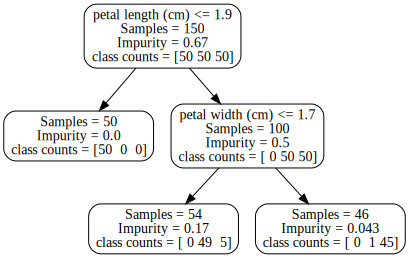

In [4]:
iris_sample_vals = iris_sample.values

# # for small sample
# X = iris_sample_vals[:,:-1]
# y = iris_sample_vals[:,-1]

X = iris_df.values[:,:-1]
y = iris_df.values[:,-1]

logger.setLevel(logging.INFO)

decision_tree = DecisionTree(n_classes=3)
decision_tree.fit(X, y)

# For info or ansii tree
# decision_tree.tree.info()
# decision_tree.tree.print_tree()

feature_names = iris_data['feature_names']
decision_tree.render(feature_names=feature_names)

### example prediction

In [5]:
decision_tree.predict(X[0,:])

1

In [6]:
decision_tree.predict(X)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 1, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 2, 1, 2, 1, 1, 2, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 1,
       0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 1, 0, 1, 2])

In [7]:
# real y values
y.astype(int)

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 0, 1,
       1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 0, 1, 1, 0, 1, 2, 2, 0, 1, 2, 2,
       0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 1, 2, 0, 1, 2])

In [8]:
(decision_tree.predict(X) == y.astype(int)).sum() / len(y)

0.96

### compare with Sklearn

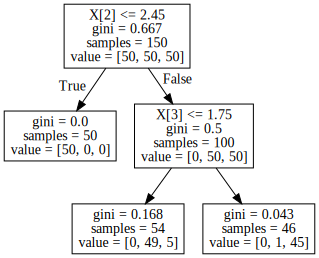

In [9]:
sk_decision_tree = DecisionTreeClassifier(
    max_depth=decision_tree.max_depth,
    min_samples_leaf=decision_tree.min_samples_leaf,
    min_samples_split=decision_tree.min_samples_split)

sk_decision_tree.fit(X, y)

# Visualize the sklearn tree
# Note - same as ours except not using midpoints between split_vals

graphviz.Source(export_graphviz(sk_decision_tree))

## Decision tree - Titanic data

### load titanic data

In [10]:
X_train = pd.read_feather('../titanic/processed/X_train.feather')
y_train = pd.read_feather('../titanic/processed/y_train.feather')
X_test = pd.read_feather('../titanic/processed/X_test.feather')
y_test = pd.read_feather('../titanic/processed/y_test.feather')

### show accuracy for small tree

In [11]:
# for best result use max depth = 4

titanic_decision_tree = DecisionTree(max_depth=2)
titanic_decision_tree.fit(X_train.values, y_train.values)
y_pred = titanic_decision_tree.predict(X_test.values)
test_acc = (y_pred == y_test.values.flatten()).sum() / len(y_test)
print(f'Test accuracy = {test_acc:.2%}')

INFO:decision_tree:Checking features [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
INFO:decision_tree:Splitting tree on feature_index 27 and feature_split_val 0.0
INFO:decision_tree:Checking features [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
INFO:decision_tree:Splitting tree on feature_index 10 and feature_split_val 0.0
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Checking features [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
INFO:decision_tree:Splitting tree on feature_index 1 and feature_split_val -0.12
INFO:decision_tree:Reached max depth or no splits reduce impurity
INFO:decision_tree:Reached max depth or no splits reduce impurity


Test accuracy = 75.42%


### Visulaise titanic tree

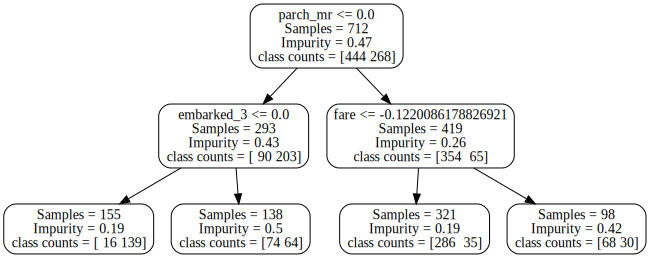

In [12]:
titanic_features = list(X_train.columns)
titanic_decision_tree.render(titanic_features)

## end